In [ ]:
# install dependencies
!pip install cython pyyaml==5.1

# install detectron2
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

In [3]:
# import detectron2
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

<Logger detectron2 (DEBUG)>

In [5]:
# import standard files
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

# import detectron2 files 
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [7]:
# make a frames directory
!rm -r frames/*
!mkdir frames/

rm: cannot remove 'frames/*': No such file or directory


In [8]:
# load and preprocess video
video = '/content/sample.mp4'

cap = cv2.VideoCapture(video)
count = 0

# check if file is opened successfully
if (cap.isOpened() == False):
    print('Error opening video stream or file')

ret, first_frame = cap.read()

# read entire video
while(cap.isOpened()):
    # capture each frame
    ret, frame = cap.read()
    
    if ret == True: # if frame return value is true
        cv2.imwrite('frames/'+str(count)+'.png', frame)
        count += 1
        if (count==750):
            break
    else:
        break

In [9]:
# get the FPS of the video stream
FPS = cap.get(cv2.CAP_PROP_FPS)
print(FPS)

25.0


In [10]:
cfg = get_cfg()

# add a project specific configuration since we are not running in detectron2 core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_C4_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.9

# find the model from detectron2 model zoo
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_C4_3x.yaml")
predictor = DefaultPredictor(cfg)

model_final_f97cb7.pkl: 136MB [00:08, 16.6MB/s]                           


In [60]:
# read image and pass to model
img = cv2.imread('frames/35.png')
outputs = predictor(img)

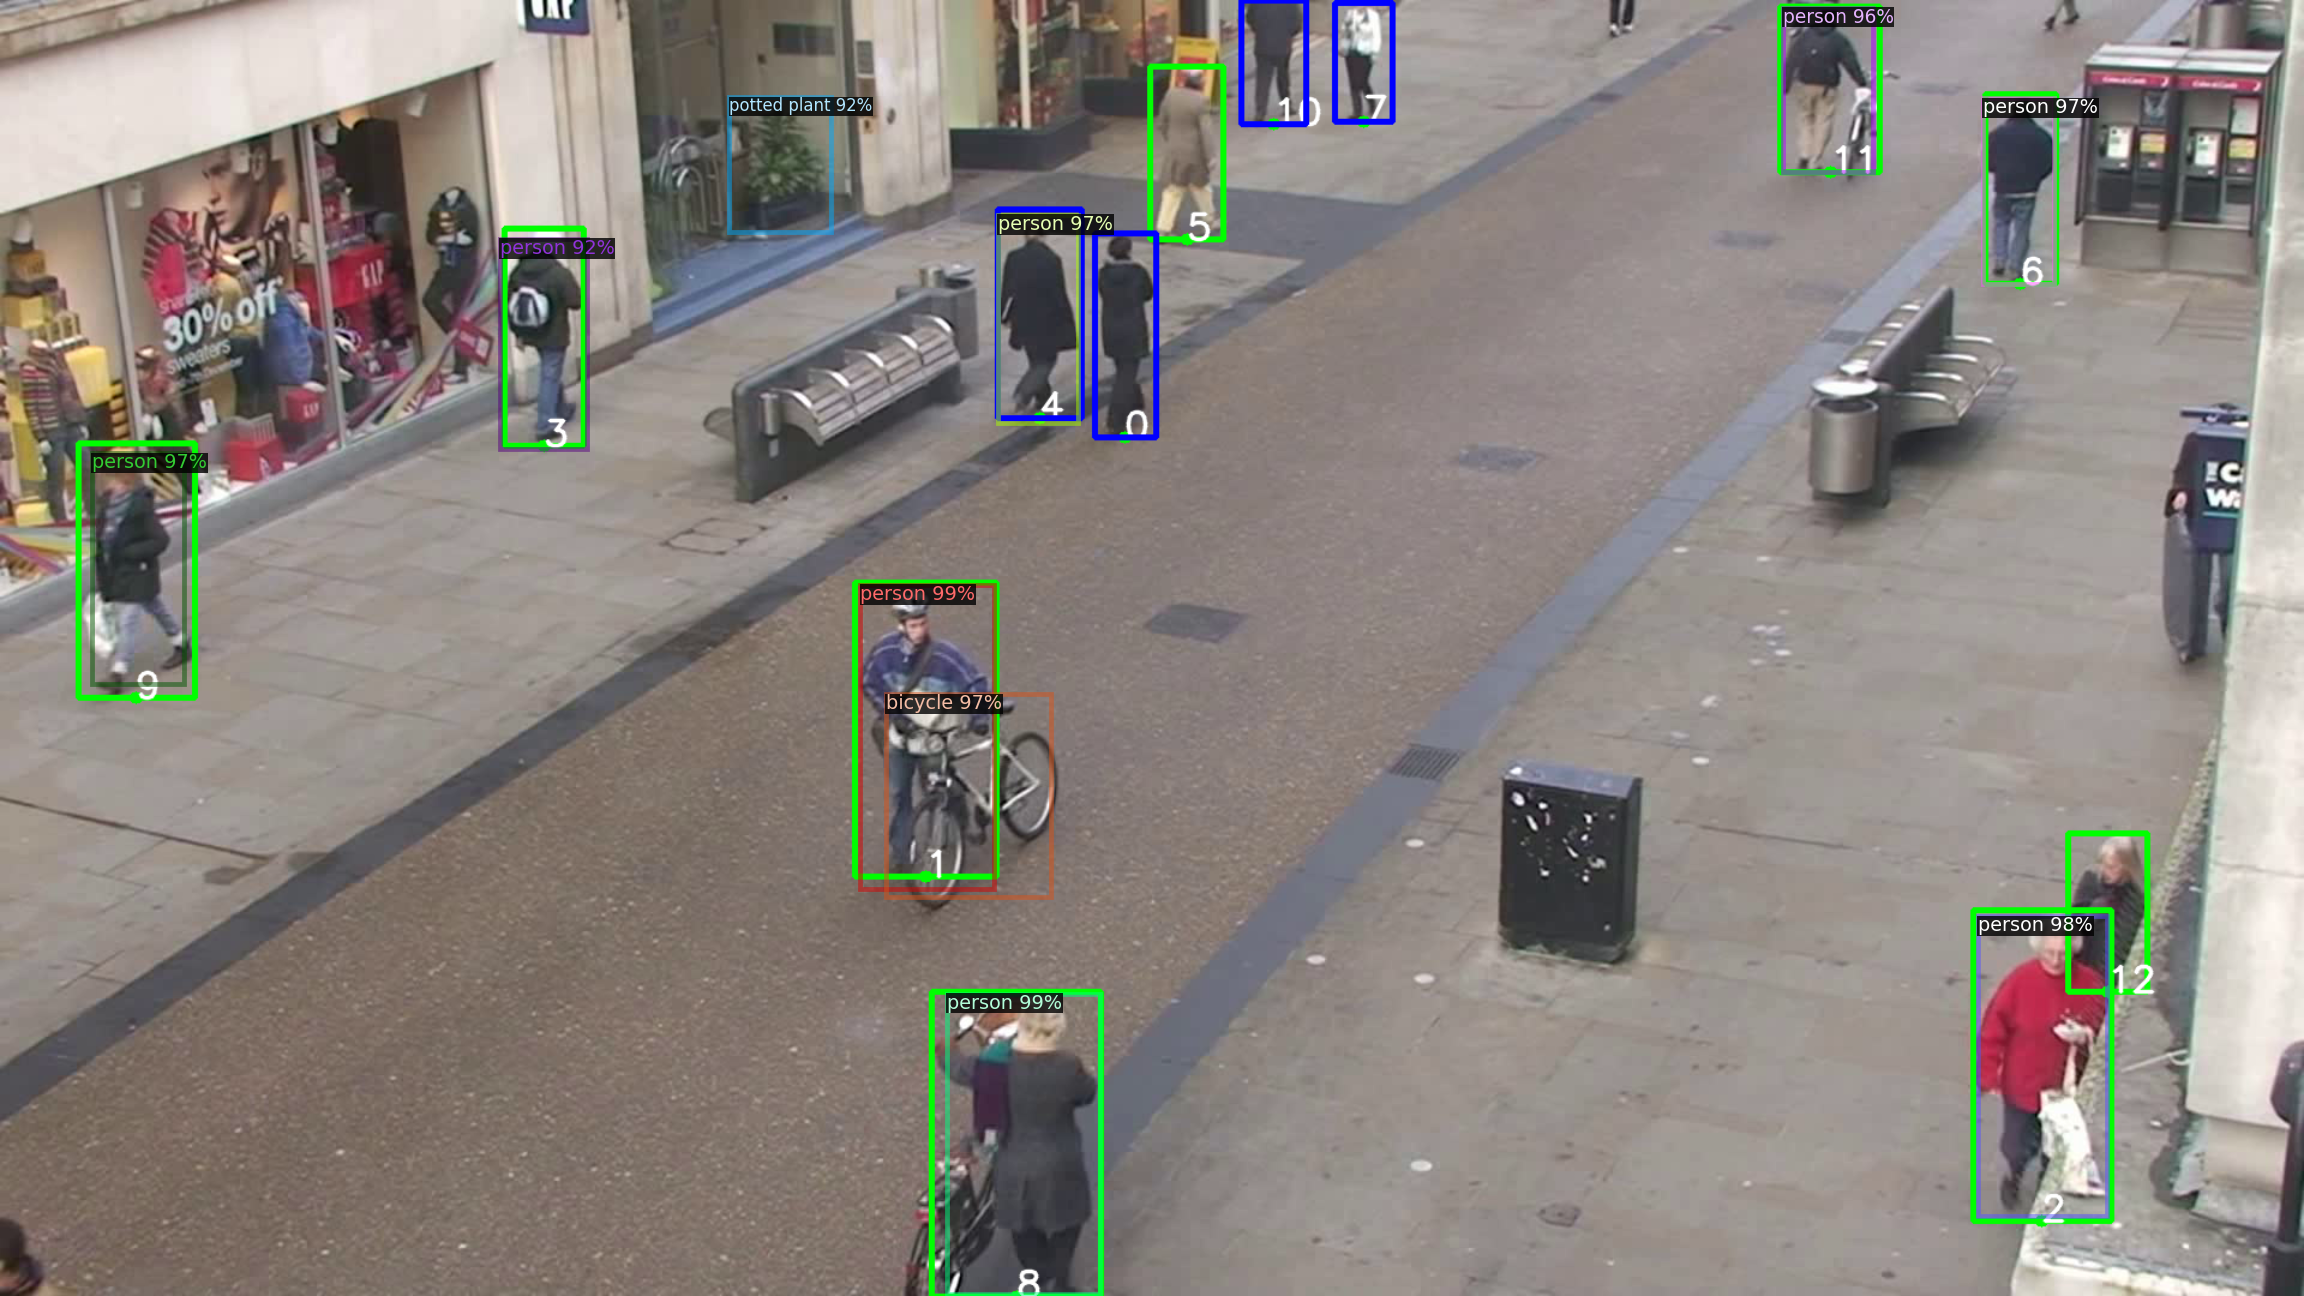

In [61]:
# use Visualizer to draw the predictions on the image
v = Visualizer(img[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs['instances'].to('cpu'))
cv2_imshow(v.get_image()[:,:,::-1])

<b>Observation</b>: The pretrained model produces outputs of multiple classes.

In [15]:
# understanding the objects present in any image
classes = outputs['instances'].pred_classes.cpu().numpy()
print(classes)

[ 0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0 58]


In [16]:
# understanding the bounding boxes in our predictor
bbox = outputs['instances'].pred_boxes.tensor.cpu().numpy()
print(bbox)

[[9.0307111e+02 1.9643094e+02 9.5503625e+02 3.6915280e+02]
 [8.1752740e+02 1.8471613e+02 8.8479517e+02 3.5732040e+02]
 [1.6538320e+03 8.3719292e+01 1.7116002e+03 2.4027617e+02]
 [7.3656433e+02 4.7810938e+02 8.5853339e+02 7.2636719e+02]
 [4.0712863e+02 1.9720728e+02 4.7474765e+02 3.7257062e+02]
 [1.6394775e+03 7.4684967e+02 1.7526091e+03 9.8874261e+02]
 [9.5370563e+02 5.5928146e+01 1.0051741e+03 2.0580592e+02]
 [7.6678082e+02 8.4728772e+02 8.9972632e+02 1.0798788e+03]
 [7.6037097e+02 5.7163464e+02 8.9783020e+02 7.4291968e+02]
 [1.0268174e+02 3.6510361e+02 1.6709456e+02 5.5395782e+02]
 [1.1175507e+03 1.4103370e+00 1.1603502e+03 9.7342072e+01]
 [1.0316117e+03 1.0614221e+00 1.0831102e+03 1.0398194e+02]
 [1.4795155e+03 5.9167094e+00 1.5633036e+03 1.5364308e+02]
 [2.1052542e+00 9.9518671e+02 1.0063387e+02 1.0800000e+03]
 [1.7352677e+03 6.8237744e+02 1.8015763e+03 8.2724084e+02]
 [7.2991471e+00 2.6897058e+02 9.7117470e+01 4.3749594e+02]
 [6.0961774e+02 8.2046005e+01 6.9233679e+02 1.9400127e+0

In [17]:
# limiting the scope of prediction to that of only people
ind = np.where(classes==0)[0]

# limiting the bbox to that of only people
person = bbox[ind]

# total no. of persons
num = len(person)

In [19]:
# understanding the format of the bounding box
x1, y1, x2, y2 = person[0]
print(x1, y1, x2, y2)

903.0711 196.43094 955.03625 369.1528


<b>Observation</b>: The bounding box has the coordinates of the 2 corner: top-left and bottom-right in the form (x1,y1) and (x2,y2)

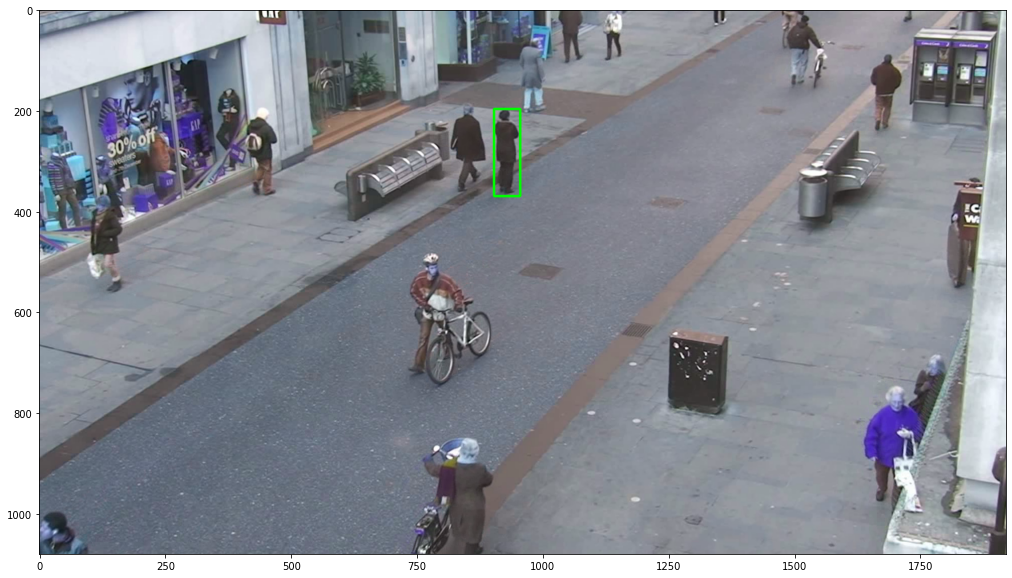

In [39]:
# drawing a bbox for one person
img = cv2.imread('frames/31.png')
_ = cv2.rectangle(img, (x1,y1), (x2,y2), (0,255,0), 4)

plt.figure(figsize=(20,10))
plt.imshow(img);

<b>Note</b>: Aim is to find out the distance between the people. Taking the center of the bbox to be the coordinates of the person and then computing the social distancing model.

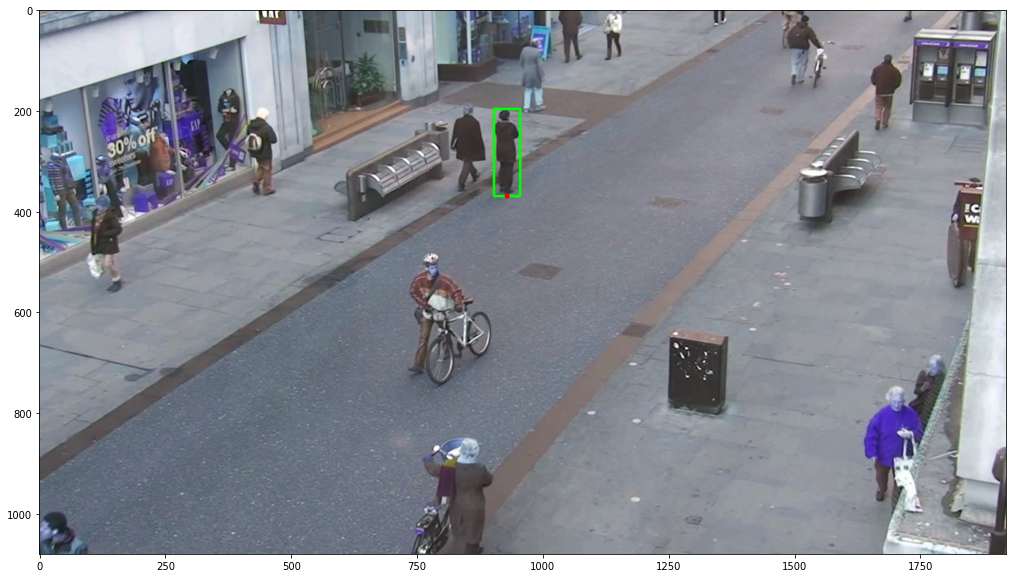

In [40]:
# computing the center
x_center = int((x1+x2)/2)
y_center = int(y2)

center = (x_center, y_center)

_ = cv2.circle(img, center, 5, (255,0,0), -1)
plt.figure(figsize=(20,10))
plt.imshow(img);

In [44]:
# a function that returns the reqd bbox and center for each frame
def mid_point(img,person,idx):
  
  # finding out the coordinates
  x1 , y1, x2, y2 = person[idx]
  _ = cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 4)
  
  # computing the bottom center of the bbox
  x_mid = int((x1+x2)/2)
  y_mid = int(y2)
  mid   = (x_mid,y_mid)
  
  _ = cv2.circle(img, mid, 5, (0, 255, 0), -1)
  cv2.putText(img, str(idx), mid, cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
  
  return mid

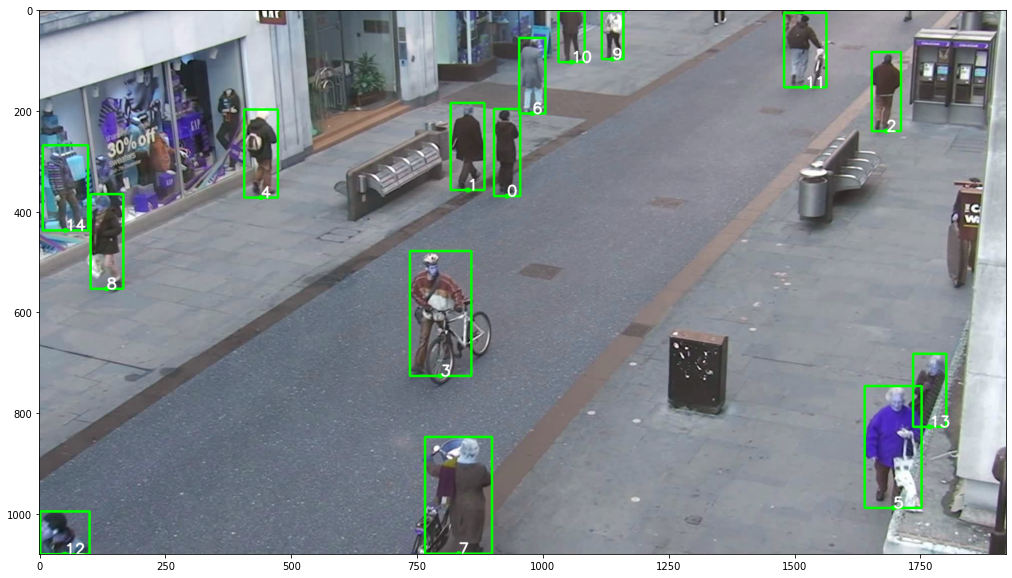

In [45]:
# set midpoints
midpoints = [mid_point(img, person, i) for i in range(len(person))]

# visualize image
plt.figure(figsize=(20,10))
plt.imshow(img)

In [43]:
# defining a funciton to compute the Euclidean distance between two points
from scipy.spatial import distance
def compute_distance(midpoints, num):
    dist = np.zeros((num,num))
    for i in range(num):
        for j in range(i+1, num):
            if i!=j:
                d = distance.euclidean(midpoints[i], midpoints[j])
                dist[i][j] = d
    return dist

In [46]:
dist = compute_distance(midpoints, num)

In [47]:
# defining a function that returns the closeest distnce between the people passing each other
def find_closest(dist, num, closest):
    p1 = []
    p2 = []
    d = []
    for i in range(num):
        for j in range(i, num):
            if (i!=j) & (dist[i][j]<=thresh):
                p1.append(i)
                p2.append(j)
                d.append(dist[i][j])
    return p1, p2, d

In [48]:
# setting a minimum threshold distance for safety
import pandas as pd

thresh = 100
p1, p2, d = find_closest(dist, num, thresh)
df = pd.DataFrame({'p1': p1,
                   'p2': p2,
                   'dist': d})
df

p1  p2       dist
0   0   1  78.917679
1   9  10  81.221918

<b>Observation</b>: Here, in frame 31, person 0 and  1 and also person 9 and 10 are lesser than permissible distancing limits and have therefore, been flagged.

In [49]:
# defining a function to set the bbox color of people not maintaining distance to red
def change_red(img, person, p1, p2):
    risky = np.unique(p1+p2)
    for i in risky:
        x1, y1, x2, y2 = person[i]
        _ = cv2.rectangle(img, (x1,y1), (x2,y2), (255,0,0), 4)
    return img

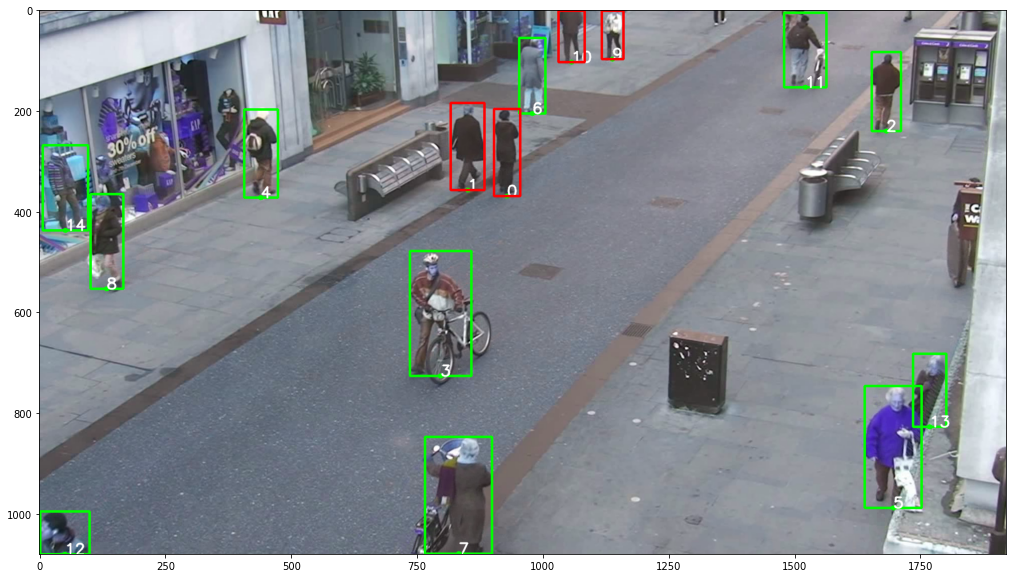

In [50]:
img = change_red(img, person, p1, p2)
plt.figure(figsize=(20,10))
plt.imshow(img)

<b>Note:</b> We now have performed all the actions that were required to process a frame in the image. Next, we'll apply the same results on the entire video feed.

In [51]:
import os, re

names = os.listdir('frames/')
names.sort(key=lambda x: int(re.sub('\D', '', x)))

In [53]:
# defining the super function that applies all the previous steps to a video
def find_closest_people(name, thresh):
    img = cv2.imread('frames/'+name)
    outputs = predictor(img)
    classes = outputs['instances'].pred_classes.cpu().numpy()
    bbox = outputs['instances'].pred_boxes.tensor.cpu().numpy()
    ind = np.where(classes==0)[0]
    person = bbox[ind]
    midpoints = [mid_point(img, person, i) for i in range(len(person))]
    num = len(midpoints)
    dist = compute_distance(midpoints, num)
    p1, p2, d = find_closest(dist, num , thresh)
    img = change_red(img, person, p1, p2)
    cv2.imwrite('frames/'+name, img)
    return 0

In [56]:
# finding the closest people in each frame
from tqdm import tqdm
thresh = 100

_ = [find_closest_people(names[i], thresh) for i in tqdm(range(len(names)))]


100%|██████████| 750/750 [14:38<00:00,  1.17s/it]


In [59]:
# converting the edited frames back into a video
frames = os.listdir('frames/')
frames.sort(key= lambda x: int(re.sub('\D', '', x)))

frame_array = []

for i in range(len(frames)):
    # reading each file
    img = cv2.imread('frames/'+frames[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    height, width, layers = img.shape
    size = (width, height)

    #inserting frames into an image array
    frame_array.append(img)

out = cv2.VideoWriter('sample_output.mp4', cv2.VideoWriter_fourcc(*'DIVX'), 25, size)

for i in range(len(frame_array)):
    # writing to an image array
    out.write(frame_array[i])

out.release()